In [1]:
import torch
import numpy as np

import cupy as cp
from cucim.skimage import measure as cucim_measure
from skimage import measure

import cc3d

def get_connected_components(img, connectivity=None):

    img_cupy = cp.asarray(img)
    labeled_img, num_features = cucim_measure.label(img_cupy, connectivity=connectivity, return_num=True)
    labeled_img_torch = torch.as_tensor(labeled_img, device=img.device)

    return labeled_img_torch, num_features

In [2]:
from timeit import timeit

# Matrix creation code remains the same
matrix1_numpy = np.zeros((10, 35, 35))
matrix1_numpy[0, 10:20, 10:20] = 1
matrix1_numpy[0, 25:28, 10:20] = 1
matrix1_numpy[0, 10:20, 21:30] = 1
matrix1_numpy[0, 5:7, 5:7] = 1

matrix2_numpy = np.zeros((10, 35, 35))
matrix2_numpy[0, 10:20, 6:14] = 1
matrix2_numpy[0, 10:20, 15:24] = 1
matrix2_numpy[0, 25:28, 6:14] = 1
matrix2_numpy[0, 25:28, 15:24] = 1
matrix2_numpy[0, 25:27, 25:27] = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
matrix1_torch = torch.as_tensor(matrix1_numpy, dtype=torch.float32).to(device)
matrix2_torch = torch.as_tensor(matrix2_numpy, dtype=torch.float32).to(device)

# Define functions to time
def cc3d_cc():
    matrix1_cc3d = cc3d.connected_components(matrix1_numpy)
    matrix2_cc3d = cc3d.connected_components(matrix2_numpy)
    return matrix1_cc3d, matrix2_cc3d

def torch_cc():
    matrix1_cc_torch, _ = get_connected_components(matrix1_torch)
    matrix2_cc_torch, _ = get_connected_components(matrix2_torch)
    torch.cuda.synchronize()  # Ensure CUDA operations are completed
    return matrix1_cc_torch, matrix2_cc_torch

def skimage_cc():
    matrix1_skimage = measure.label(matrix1_numpy)
    matrix2_skimage = measure.label(matrix2_numpy)
    return matrix1_skimage, matrix2_skimage

# Time the functions
cc3d_time = timeit(cc3d_cc, number=100)
torch_time = timeit(torch_cc, number=100)
skimage_cc_time = timeit(skimage_cc, number=100)

# Run once to get results for comparison
matrix1_cc3d, matrix2_cc3d = cc3d_cc()
matrix1_cc_torch, matrix2_cc_torch = torch_cc()
matrix1_skimage, matrix2_skimage = skimage_cc()

print('Are the connected components equal?')
print('Matrix1 torch & cc3d:', np.allclose(matrix1_cc_torch.cpu().numpy(), matrix1_cc3d))
print('Matrix2 torch & cc3d:', np.allclose(matrix2_cc_torch.cpu().numpy(), matrix2_cc3d))
print('Matrix1 skimage & torch:', np.allclose(matrix1_skimage, matrix1_cc_torch.cpu().numpy()))
print('Matrix2 skimage & torch:', np.allclose(matrix2_skimage, matrix2_cc_torch.cpu().numpy()))

Are the connected components equal?
Matrix1 torch & cc3d: True
Matrix2 torch & cc3d: True
Matrix1 skimage & torch: True
Matrix2 skimage & torch: True


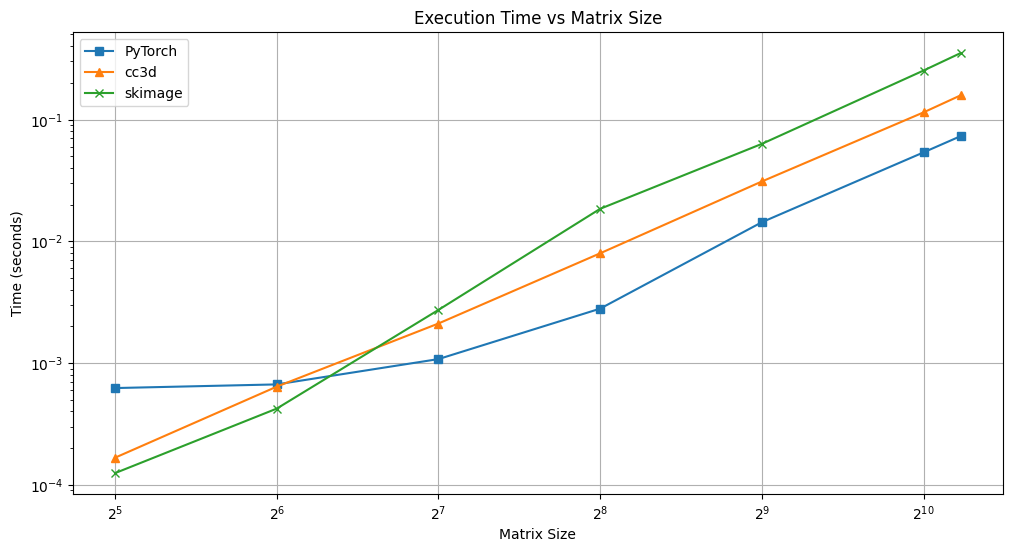

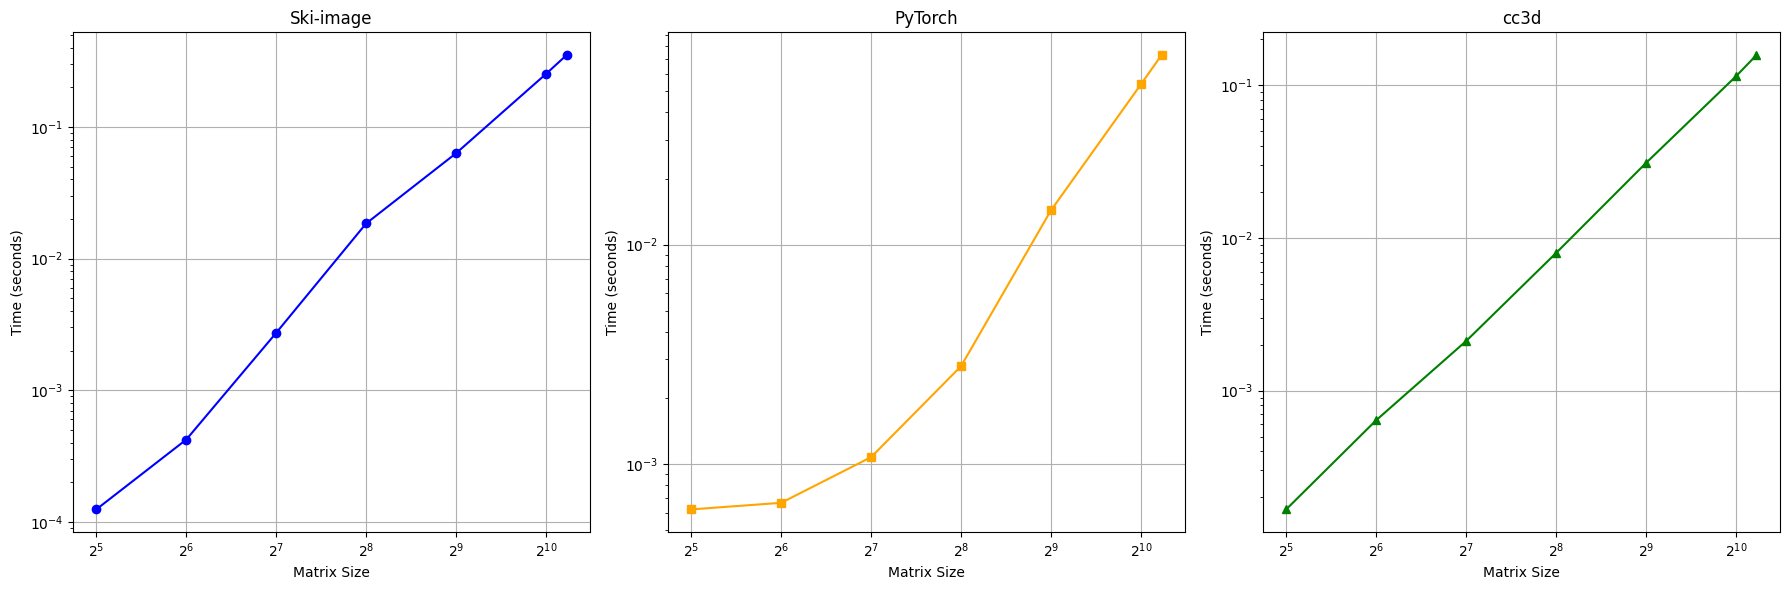

In [3]:
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def create_matrix(size):
    matrix = np.zeros((50, size, size))
    matrix[0, size//4:size//2, size//4:size//2] = 1
    matrix[0, 3*size//4:7*size//8, size//4:size//2] = 1
    matrix[0, size//4:size//2, 5*size//8:3*size//4] = 1
    return matrix

def torch_cc(matrix):
    matrix_torch = torch.as_tensor(matrix, dtype=torch.float32).to(device)
    result = get_connected_components(matrix_torch)
    torch.cuda.synchronize()
    return result

def cc3d_cc(matrix):
    return cc3d.connected_components(matrix)

def skimage_cc(matrix):
    return measure.label(matrix)

sizes = [32, 64, 128, 256, 512, 1024, 1200]
numpy_times = []
torch_times = []
cc3d_times = []
skimage_cc_times = []

for size in sizes:
    matrix = create_matrix(size)
    
    torch_time = timeit(lambda: torch_cc(matrix), number=10) / 10
    cc3d_time = timeit(lambda: cc3d_cc(matrix), number=10) / 10
    skimage_cc_time = timeit(lambda: skimage_cc(matrix), number=10) / 10
    
    torch_times.append(torch_time)
    cc3d_times.append(cc3d_time)
    skimage_cc_times.append(skimage_cc_time)
    
    # print(f"Size: {size}x{size}")
    # print(f"PyTorch time: {torch_time:.6f} seconds")
    # print(f"cc3d time: {cc3d_time:.6f} seconds")
    # print(f"skimage time: {skimage_cc_time:.6f} seconds")
    # print()

plt.figure(figsize=(12, 6))
plt.plot(sizes, torch_times, marker='s', label='PyTorch')
plt.plot(sizes, cc3d_times, marker='^', label='cc3d')
plt.plot(sizes, skimage_cc_times, marker='x', label='skimage')
plt.title('Execution Time vs Matrix Size')
plt.xlabel('Matrix Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.xscale('log', base=2)
plt.yscale('log')
plt.grid(True)
plt.savefig('connected_components_comparison_line_graph.png')
plt.show()

# Create separate plots for each method
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(sizes, skimage_cc_times, marker='o', color='blue')
ax1.set_title('Ski-image')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time (seconds)')
ax1.set_xscale('log', base=2)
ax1.set_yscale('log')
ax1.grid(True)

ax2.plot(sizes, torch_times, marker='s', color='orange')
ax2.set_title('PyTorch')
ax2.set_xlabel('Matrix Size')
ax2.set_ylabel('Time (seconds)')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')
ax2.grid(True)

ax3.plot(sizes, cc3d_times, marker='^', color='green')
ax3.set_title('cc3d')
ax3.set_xlabel('Matrix Size')
ax3.set_ylabel('Time (seconds)')
ax3.set_xscale('log', base=2)
ax3.set_yscale('log')
ax3.grid(True)

plt.tight_layout()
# plt.savefig('connected_components_comparison_separate_plots.png')
plt.show()